In [1]:
#
##
### LITTLE HELPERS

import pandas as pd
import numpy as np
from itertools import product

def _optimize_numeric_dtypes(df):
    import pandas as pd
    float_cols = df.select_dtypes("float").columns
    int_cols = df.select_dtypes("integer").columns
    df[float_cols] = df[float_cols].\
        apply(pd.to_numeric, downcast="float")
    df[int_cols] = df[int_cols].\
        apply(pd.to_numeric, downcast="integer")
    return df

def get_data(path="../data/customer_model/retailrocket/"):
    data = _optimize_numeric_dtypes(
        pd.read_parquet(path))
    #data = data.loc[:,["user_id","target_event", "target_customer_value_lag1", "target_customer_value"]]
    return data

In [2]:
# descriptive stats

from scipy.stats import skew, skewtest, kurtosis, kurtosistest

# push out the stats
def get_stats(x):
    out_vec = [x.mean(), x.std(), x.min(), x.max(), x.median(),
        skew(x), kurtosis(x),
        1.0-np.sum(x!=-1)/len(x), 1.0-(np.count_nonzero(x)/len(x))]
    return out_vec

def save_stats(data, path):
    stats_data = data.apply(get_stats)
    stats_data["stats"] = ["mean", "std", "min","max", "median",
        "skew", "kurt", "miss", "sparse"]
    stats_data.set_index("stats", inplace=True)
    stats_data.T.to_csv(path)
    return None

rr_data = get_data("../data/customer_model/retailrocket/")
rees46_data = get_data("../data/customer_model/rees46/")

#save_stats(rr_data, "../data/customer_model/retailrocket-desc-stats.csv")
#save_stats(rees46_data, "../data/customer_model/rees46-desc-stats.csv")

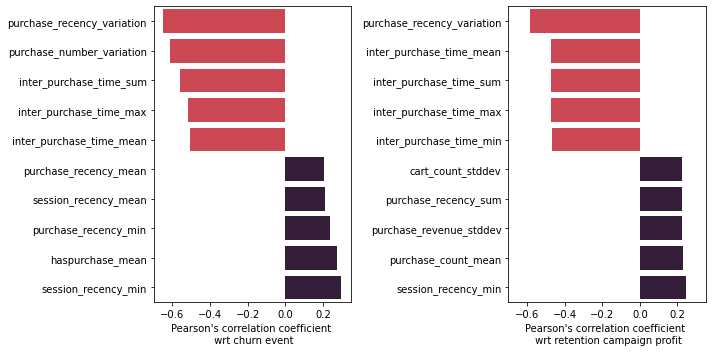

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

def get_target_corr(data, target):

    cols = [c for c in data.columns if ("target_" not in c)&\
        (c not in ["row_id", "time_step", "user_id"])]
    event_sorted = data.loc[:,[target]+cols].corr()[target].dropna().sort_values()
    event_sorted = event_sorted[[c for c in event_sorted.index if "target_" not in c]]
    return pd.concat([event_sorted.head(5), event_sorted.tail(5)])
    #features = ["session_recency_min", "purchase_recency_min",
    #    "session_number_max", "purchase_number_max",
    #    "view_revenue_sum", "purchase_revenue_sum"]
    #return event_sorted[features]
    

def plot_target_corrs(event, profit, xlim):
    f, axs = plt.subplots(1,2, figsize=(10,5))
    # event
    cust_pal = {v:sns.color_palette("rocket")[0] if event[v]>0 else sns.color_palette("rocket")[3]\
        for v in event.index}
    ax = sns.barplot(y=event.index, x=event, palette=cust_pal, ax=axs[0]);
    ax.set_xlim(xlim);
    ax.set_xlabel("Pearson's correlation coefficient \n wrt churn event");
    # profit
    cust_pal = {v:sns.color_palette("rocket")[0] if profit[v]>0 else sns.color_palette("rocket")[3]\
        for v in profit.index}
    ax = sns.barplot(y=profit.index, x=profit, palette=cust_pal, ax=axs[1]);
    ax.set_xlim(xlim);
    ax.set_xlabel("Pearson's correlation coefficient \n wrt retention campaign profit");
    f.tight_layout()          

# data
events = get_target_corr(rr_data, "target_event")
profit = get_target_corr(rr_data, "target_actual_profit")
plot_target_corrs(events, profit, (-.7,.35))

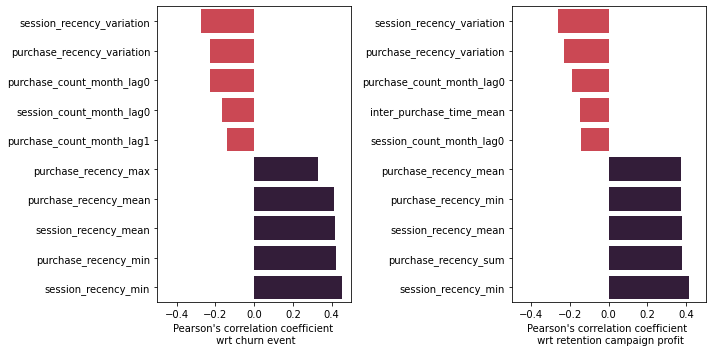

In [15]:
events = get_target_corr(rees46_data, "target_event")
profit = get_target_corr(rees46_data, "target_actual_profit")
plot_target_corrs(events, profit, (-.5,.5))
del events, profit

/home/mf/github/churn-modeling/.env/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/mf/github/churn-modeling/.env/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


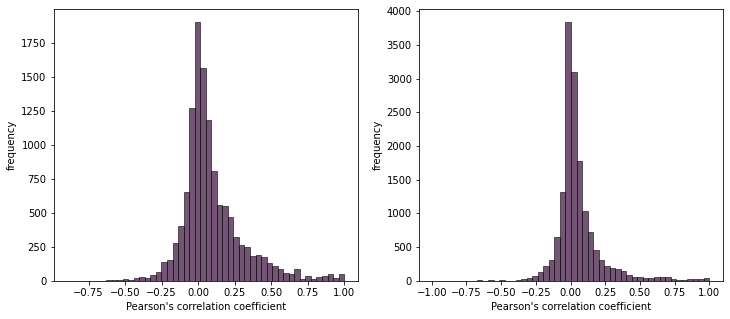

In [9]:

from itertools import combinations
from scipy.stats import pearsonr

def get_int_corr(data):
    prod = list(combinations(data.columns,r=2))
    corr_ls = []
    for c in prod:
        stat, pval = pearsonr(data[c[0]],data[c[1]])
        corr_ls.append([c[0], c[1], stat, pval])
    corr_df = pd.DataFrame(corr_ls)
    corr_df.columns = ["from", "to", "rho", "pvalue"]
    corr_df.dropna(inplace=True)
    cols = set([c for c in data.columns if ("target_" not in c)&\
        (c not in ["row_id", "time_step", "user_id"])])
    int_corr_df = corr_df.loc[corr_df["from"].isin(cols) & corr_df["to"].isin(cols),:]
    int_corr_df = int_corr_df.loc[int_corr_df["from"]>int_corr_df["to"],:]
    return int_corr_df    

# data
rr_int_corr = get_int_corr(rr_data)
rees46_int_corr = get_int_corr(rees46_data)

# plots
f, axs = plt.subplots(1,2, figsize=(12,5))
sns.histplot(data=rr_int_corr, x="rho", bins=50, ax=axs[0],
    color=sns.color_palette("rocket",10)[1]);
axs[0].set_ylabel("frequency");
axs[0].set_xlabel("Pearson's correlation coefficient");

sns.histplot(data=rees46_int_corr, x="rho", bins=50, ax=axs[1],
    color=sns.color_palette("rocket",10)[1]);
axs[1].set_ylabel("frequency");
axs[1].set_xlabel("Pearson's correlation coefficient");